In [1]:
import cv2
import numpy as np
import toml
import os
import msgpack as mp
import msgpack_numpy as mpn
import matplotlib.pyplot as plt
from cv2 import aruco
from tqdm import tqdm
import polars as pl
from pd_support import *

from scipy.spatial.transform import Rotation as R

Loading camera calibration

In [2]:
data = toml.load("../calib_testing.toml")
camera_matrix = np.array(data["calibration"]["camera_matrix"]).reshape(3, 3)
dist_coeff = np.array(data["calibration"]["dist_coeffs"])


_parent_dir = os.path.join(os.path.dirname(os.getcwd()), "data")
_folder_name = "record_1200_400_waf"
_base_pth = os.path.join(_parent_dir, "recordings", _folder_name)

In [3]:
camera_matrix

array([[1.87037605e+03, 0.00000000e+00, 4.58858429e+02],
       [0.00000000e+00, 1.48574248e+03, 7.67419572e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [4]:
ARUCO_PARAMETERS = aruco.DetectorParameters()
ARUCO_DICT = aruco.getPredefinedDictionary(aruco.DICT_ARUCO_MIP_36H12)
detector = aruco.ArucoDetector(ARUCO_DICT, ARUCO_PARAMETERS)
markerLength = 0.05
markerSeperation = 0.01

default_ids = [12, 88, 89]

board = aruco.GridBoard(
    size=[1, 1],
    markerLength=markerLength,
    markerSeparation=markerSeperation,
    dictionary=ARUCO_DICT,
)

In [5]:
def estimate_pose_single_markers(
    corners, marker_size, camera_matrix, distortion_coefficients
):
    marker_points = np.array(
        [
            [-marker_size / 2, marker_size / 2, 0],
            [marker_size / 2, marker_size / 2, 0],
            [marker_size / 2, -marker_size / 2, 0],
            [-marker_size / 2, -marker_size / 2, 0],
        ],
        dtype=np.float32,
    )
    rvecs = []
    tvecs = []
    for corner in corners:
        _, r, t = cv2.solvePnP(
            marker_points,
            corner,
            camera_matrix,
            distortion_coefficients,
            True,
            flags=cv2.SOLVEPNP_IPPE_SQUARE,
        )
        if r is not None and t is not None:
            r = np.array(r).reshape(1, 3).tolist()
            t = np.array(t).reshape(1, 3).tolist()
            rvecs.append(r)
            tvecs.append(t)
    return np.array(rvecs, dtype=np.float32), np.array(tvecs, dtype=np.float32)

In [6]:
rvecs, tvecs = [], []
with open(os.path.join(_base_pth, "webcam_color.msgpack"), "rb") as _f:
    unpacker = mp.Unpacker(_f, object_hook=mpn.decode)
    img_size = next(unpacker)
    for _frame in tqdm(unpacker):
        corners, ids = _frame

        if (ids is not None and len(ids) > 0) and all(
            item in default_ids for item in np.array(ids)
        ):
            rotation_vectors, translation_vectors = estimate_pose_single_markers(
                corners=corners,
                marker_size=0.05,
                camera_matrix=camera_matrix,
                distortion_coefficients=dist_coeff,
            )
            rvecs.append(rotation_vectors[0][0])
            tvecs.append(translation_vectors[0][0])

        else:
            rvecs.append(np.array([np.nan, np.nan, np.nan]))
            tvecs.append(np.array([np.nan, np.nan, np.nan]))

timestamp = []
sync = []

with open(os.path.join(_base_pth, "webcam_timestamp.msgpack"), "rb") as _f:
    unpacker = mp.Unpacker(_f, object_hook=mpn.decode)
    for _p in unpacker:
        sync.append(_p[0])
        timestamp.append(_p[1])
tvecs = np.array(tvecs)
rvecs = np.array(rvecs)
sync = np.array(sync).astype(bool)

890it [00:00, 35103.73it/s]


In [7]:
ar_dict = {
    "time": timestamp,
    "sync": sync,
    "x": tvecs[:, 0],
    "y": tvecs[:, 1],
    "z": tvecs[:, 2],
    "rx": rvecs[:, 0],
    "ry": rvecs[:, 1],
    "rz": rvecs[:, 2],
}
ar_df = pl.from_dict(ar_dict)
if type(ar_df["time"][0]) is not datetime:
    ar_df = ar_df.with_columns(pl.col("time").str.to_datetime())

In [8]:
ar_df["x"][1]

0.055158402770757675

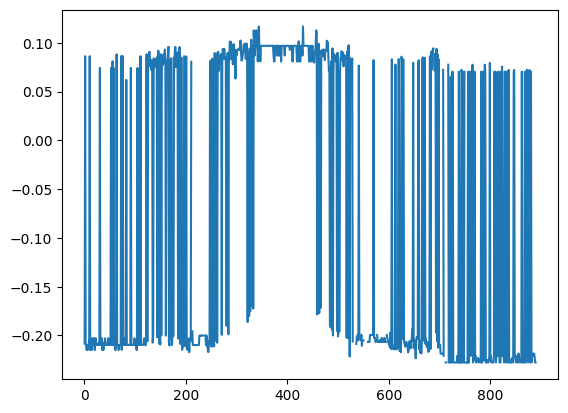

In [24]:
# plt.plot(ar_df['rx'])
plt.plot(ar_df["ry"])
# plt.plot(ar_df['rz'])

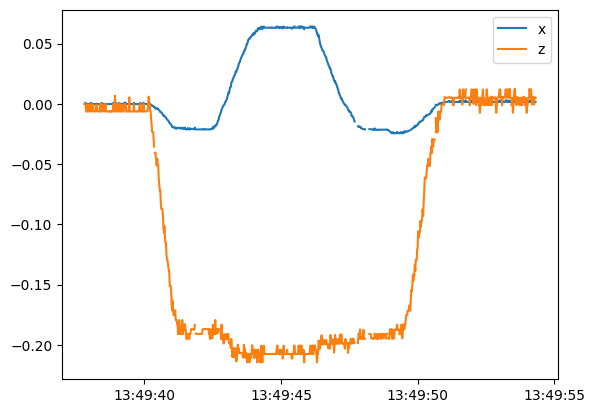

In [9]:
plt.plot(ar_df["time"], ar_df["x"] - ar_df["x"][1], label="x")
plt.plot(ar_df["time"], ar_df["z"] - ar_df["z"][1], label="z")
plt.legend()

In [10]:
t_dict = {"x": [], "y": [], "z": []}
rmat = cv2.Rodrigues(ar_df[["rx", "ry", "rz"]][1].to_numpy())[0]

for i in range(len(ar_df["time"])):
    tvec = rmat.T @ (
        ar_df[["x", "y", "z"]][i].to_numpy().reshape(3, 1)
        - ar_df[["x", "y", "z"]][1].to_numpy().reshape(3, 1)
    )
    tvec = tvec.T[0]
    t_dict["x"].append(tvec[0])
    t_dict["y"].append(tvec[1])
    t_dict["z"].append(tvec[2])

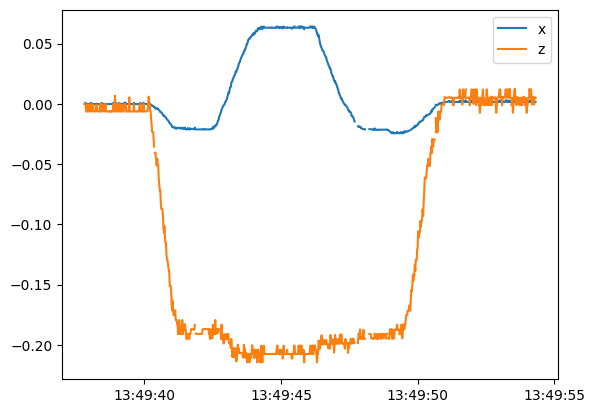

In [11]:
plt.plot(ar_df["time"], ar_df["x"] - ar_df["x"][1], label="x")
plt.plot(ar_df["time"], ar_df["z"] - ar_df["z"][1], label="z")
plt.legend()

Text(0.5, 1.0, 'transformed')

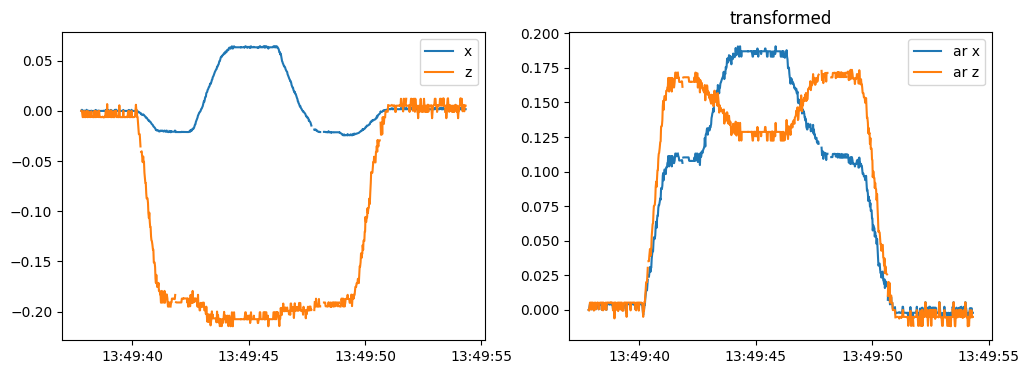

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))  # Specify the figure size


ax1.plot(ar_df["time"], ar_df["x"] - ar_df["x"][1], label="x")
ax1.plot(ar_df["time"], ar_df["z"] - ar_df["z"][1], label="z")
ax1.legend()

ax2.plot(ar_df["time"], t_dict["x"], label="ar x")
ax2.plot(ar_df["time"], t_dict["z"], label="ar z")
ax2.legend()
ax2.set_title("transformed")

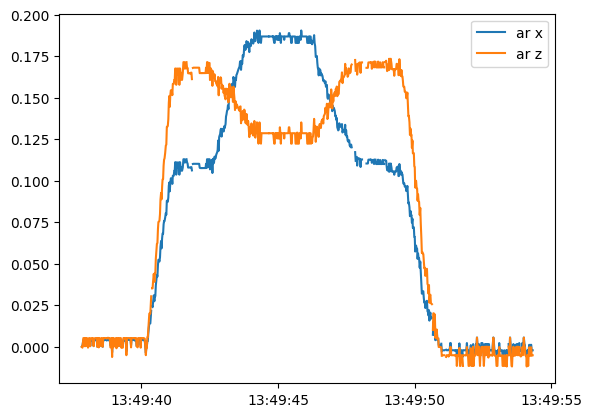

In [13]:
plt.plot(ar_df["time"], t_dict["x"], label="ar x")
plt.plot(ar_df["time"], t_dict["z"], label="ar z")
plt.legend()

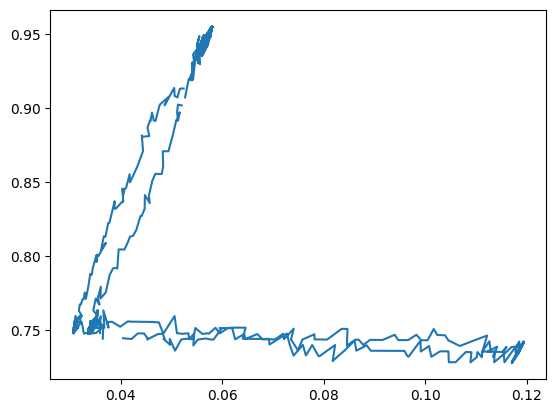

In [14]:
plt.plot(ar_df["x"], ar_df["z"])

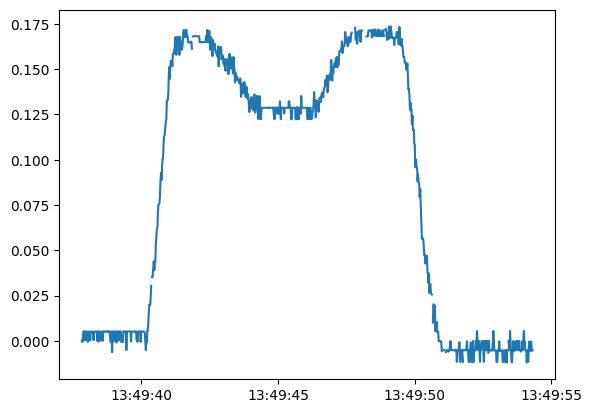

In [15]:
plt.plot(ar_df["time"], np.array(t_dict["z"]))

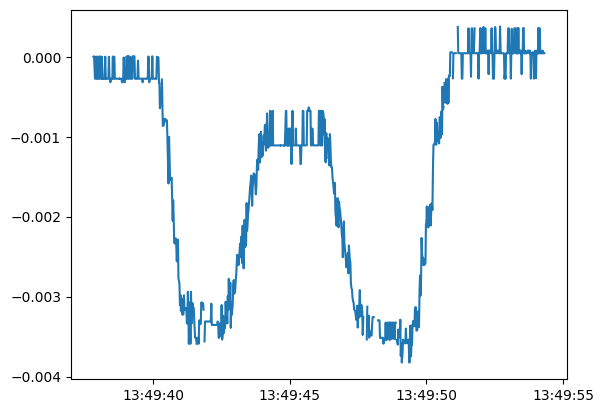

In [16]:
plt.plot(ar_df["time"], t_dict["y"])